# Compare different investment strategies

This notebook is inspired by the Prof. Coletti's analysis, described in [this youtube video](https://colab.research.google.com/drive/1WK21cNXyuHBQvwllb71YI-v5kDjE0C9V?usp=sharing) and reachable in [this colab notebook](https://colab.research.google.com/drive/1WK21cNXyuHBQvwllb71YI-v5kDjE0C9V?usp=sharing). 

The idea is simple: compare different investment strategies, focusing on **passive** approaches.

Specifically, the aim is to compare the well known and widely discussed strategies "Equal Weight" and "Market Cap Weight", while also considering a "Return Weighted" strategy. More details below.

In [1]:
import numpy as np
import polars as pl
import yfinance as yf
import json
import requests
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
REPO_URL = "https://api.github.com/repos/paolocole"
RAW_DATA_URL = "https://raw.githubusercontent.com/paolocole"
REPO_NAME = "Stock-Indexes-Historical-Data"
REPO_URL = f"{REPO_URL}/{REPO_NAME}"

In [3]:
response = requests.get(
    f"{REPO_URL}/git/trees/main?recursive=1"
)

json_response = json.loads(response.text)

In [4]:
# Dictionary with the name of the country as key and the dataframe as value.
dfs = {}

# Each country has different available dates, 
# so we need some workaround to make a unique dataframe.
DATE_COLUMN = "Date"
dates = set()

for branch in json_response["tree"]:
    if ("NET/EUR/LARGE_AND_MID_CAP/COUNTRIES" in branch["path"]) and "csv" in branch[
        "path"
    ]:
        
        country_name = branch["path"]

        filename = (
            f"{RAW_DATA_URL}/{REPO_NAME}/main/{urllib.parse.quote(country_name)}"
        )
        
        curr_df = pl.read_csv(
                filename,
                new_columns=[DATE_COLUMN, filename[filename.rfind("/")+1:-4].replace("%20"," ")]
            )
        
        dates = dates.union(set(curr_df.select(DATE_COLUMN).to_series().to_list()))

        dfs[country_name] = curr_df

In [5]:
print(f"There are {len(dfs)} MSCI indexes and {len(dates)} dates.")

There are 103 MSCI indexes and 296 dates.


In [6]:
dates = sorted(list(dates))

counts = [0 for _ in range(len(dates))]

for df in dfs.values():
    for date in dates:
        if date in df.select(DATE_COLUMN).to_series().to_list():
            counts[dates.index(date)] += 1

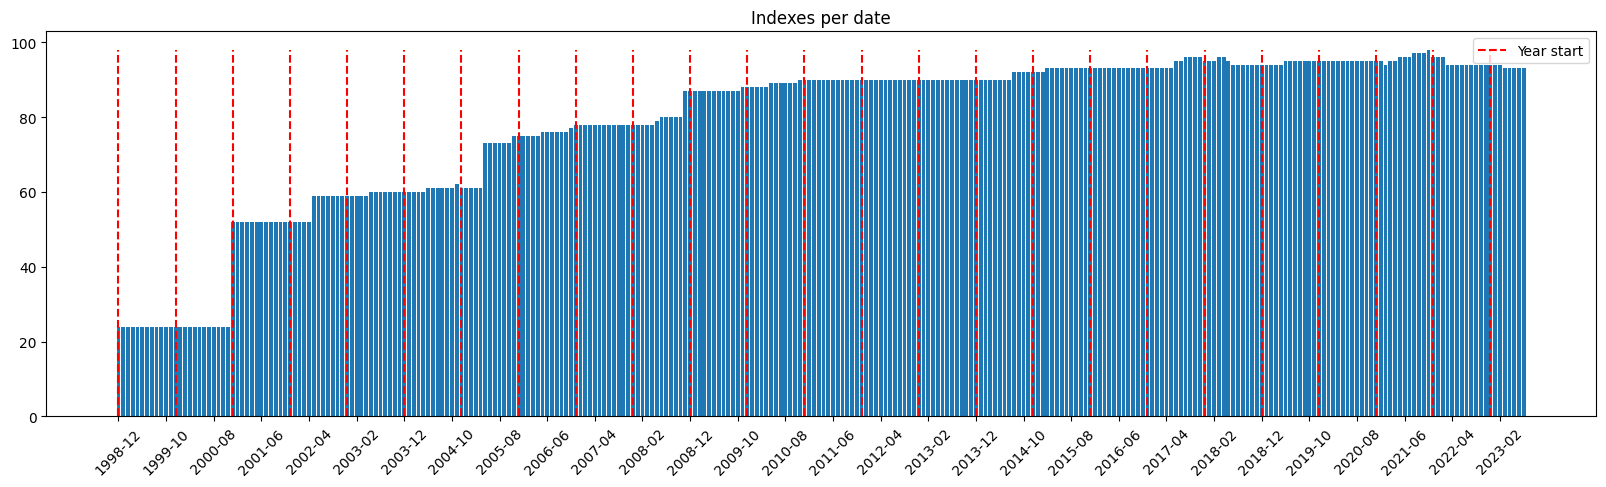

In [7]:
plt.figure(figsize=(20, 5))
plt.bar(dates, counts)
plt.title("Indexes per date")

skip = 10
plt.xticks(ticks=range(0, len(dates), skip), labels=dates[::skip], rotation=45);

all_years = list(map(lambda date: int(date.split("-")[0]), dates))
exclude_years = [1998]
all_years = list(filter(lambda x: x not in exclude_years, all_years))

unique_years = set(all_years)
plt.vlines(list(map(lambda x: all_years.index(x), unique_years)), 0, max(counts), colors="r", linestyles="dashed", label="Year start")

plt.legend();

In [8]:
data = pl.DataFrame({DATE_COLUMN : dates})

for country_name, df in dfs.items():
    
    data = data.join(df, on=DATE_COLUMN, how="left")

data = data.sort(DATE_COLUMN)

In [9]:
print(f"Initial shape: {data.shape}")

# Remove year 1998 as it has only 1 index
data = data.filter(~pl.col(DATE_COLUMN).str.starts_with("1998"))

print(f"Going to shape: {data.shape}")

# Remove rows with all NaN values (even though we should 
# have at least one index per date)

data = data.filter(pl.any_horizontal(pl.all().is_not_null()))
print(f"Going to shape: {data.shape}")

# Remove columns with all NaN values

cols = data.columns
data = data[:, [not (s.null_count() == data.height) for s in data]]
print("Dropped columns:", set(cols) - set(data.columns))

# Drop duplicates

data = data.unique()
print(f"Going to shape: {data.shape}")

print(f"Final shape: {data.shape}")

Initial shape: (296, 104)
Going to shape: (295, 104)
Going to shape: (295, 104)
Dropped columns: {'MSCI SENEGAL', 'MSCI IVORY COAST', 'MSCI USA 4%25 Decrement Index'}
Going to shape: (295, 101)
Final shape: (295, 101)


In [10]:
# Now we need to adjust Russia, as apparently its values don't match
# the real ones. Prof Coletti sets the values from 2022-3 to 0.001
RUSSIA_COLS = list(filter(lambda x: "RUSSIA" in x, data.columns))

In [11]:
data = data.with_columns([
  pl.when(pl.col(DATE_COLUMN).ge("2022-3")).then(0.001).otherwise(pl.col(column_name)).alias(column_name)
  for column_name in RUSSIA_COLS  
])

In [14]:
# Fill null values with the previous ones, up to 6
data = data.sort(DATE_COLUMN).with_columns(pl.all().fill_null(strategy="forward", limit=6))

In [15]:
# All indices comprehend dividents, already taxed.

print("Available indices: ")
for i in range(0, len(data.columns), 10):
    print(data.columns[i:i+10])

Available indices: 
['Date', 'MSCI ARGENTINA', 'MSCI AUSTRALIA', 'MSCI AUSTRIA', 'MSCI BAHRAIN DOMESTIC', 'MSCI BAHRAIN', 'MSCI BANGLADESH', 'MSCI BELGIUM', 'MSCI BOSNIA AND HERZEGOVINA', 'MSCI BOTSWANA']
['MSCI BRAZIL ADR', 'MSCI BRAZIL', 'MSCI BULGARIA', 'MSCI CANADA', 'MSCI CHILE', 'MSCI CHINA 50', 'MSCI CHINA A 50 CONNECT RMB', 'MSCI CHINA A 50 CONNECT', 'MSCI CHINA A 50', 'MSCI CHINA A INCLUSION RMB']
['MSCI CHINA A INCLUSION', 'MSCI CHINA A RMB', 'MSCI CHINA A', 'MSCI CHINA WITH PARTIAL A SHARES', 'MSCI CHINA', 'MSCI COLOMBIA', 'MSCI CROATIA', 'MSCI CZECH REPUBLIC', 'MSCI DENMARK', 'MSCI EGYPT']
['MSCI ESTONIA', 'MSCI FINLAND', 'MSCI FRANCE', 'MSCI GERMANY', 'MSCI GHANA', 'MSCI GREECE', 'MSCI Greece Rebased Index', 'MSCI HONG KONG', 'MSCI HUNGARY', 'MSCI INDIA DOMESTIC']
['MSCI INDIA', 'MSCI INDONESIA', 'MSCI IRELAND', 'MSCI ISRAEL', 'MSCI ITALY', 'MSCI JAMAICA', 'MSCI JAPAN', 'MSCI JORDAN', 'MSCI KAZAKHSTAN', 'MSCI KENYA']
['MSCI KOREA', 'MSCI KUWAIT DOMESTIC', 'MSCI KUWAIT', 'M

In [16]:
DATA_FOLDER = "data"
PATH_TO_DATA_FOLDER = os.path.join("..", DATA_FOLDER)

In [17]:
etf_weights = json.load(open(os.path.join(PATH_TO_DATA_FOLDER, "etf_weights.json"), "r"))  # etfs list

In [18]:
# Russia weights was 1.5 @ January 2022, so now it is 1.5 * 0.001 / price @ January 2022

etf_weights["MSCI RUSSIA VALUE"] = 1.5 * 0.001 / data.filter(pl.col(DATE_COLUMN) == "2022-01").select("MSCI RUSSIA VALUE").item()

In [19]:
assert len(data.select(etf_weights.keys()).columns) == len(etf_weights)

In [20]:
data = data.select([DATE_COLUMN] + sorted(list(etf_weights.keys()))).sort(DATE_COLUMN)
data

Date,MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHILE,MSCI CHINA,MSCI COLOMBIA,MSCI DENMARK,MSCI EGYPT,MSCI FINLAND,MSCI FRANCE,MSCI GERMANY,MSCI Greece Rebased Index,MSCI HONG KONG,MSCI HUNGARY,MSCI INDIA,MSCI INDONESIA,MSCI IRELAND,MSCI ISRAEL,MSCI ITALY,MSCI JAPAN,MSCI KOREA,MSCI KUWAIT,MSCI MALAYSIA,MSCI MEXICO,MSCI NETHERLANDS,MSCI NEW ZEALAND,MSCI NORWAY,MSCI PHILIPPINES,MSCI POLAND,MSCI PORTUGAL,MSCI QATAR,MSCI RUSSIA VALUE,MSCI SAUDI ARABIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI TAIWAN,MSCI THAILAND,MSCI TURKEY,MSCI UNITED ARAB EMIRATES,MSCI UNITED KINGDOM,MSCI USA
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1999-01""",109.626282,97.216926,100.112295,null,111.965322,null,null,null,99.745621,null,114.099314,106.400575,105.110024,118486.967177,96.517295,null,null,null,105.139144,null,97.988146,104.148834,null,null,null,null,95.634688,113.629621,114.115874,null,null,107.503437,null,null,null,103.8443,null,101.643311,109.507014,100.975056,null,null,null,null,102.329968,107.835743
"""1999-02""",110.53245,106.152064,98.885124,null,109.226011,null,null,null,94.301116,null,111.345117,102.861165,99.762066,120992.97753,100.844161,null,null,null,108.534914,null,99.885984,105.380212,null,null,null,null,98.257028,117.692237,107.267499,null,null,103.67035,null,null,null,106.120808,null,103.142167,110.553685,101.059233,null,null,null,null,108.212951,108.410795
"""1999-03""",117.109713,107.615208,94.826811,null,115.634686,null,null,null,94.242517,null,128.329928,106.527973,98.689626,118772.657006,115.992218,null,null,null,108.491231,null,105.492322,122.014403,null,null,null,null,100.939961,116.94922,119.780824,null,null,98.299846,null,null,null,119.900751,null,100.992883,114.625801,101.610812,null,null,null,null,113.463298,114.783645
"""1999-04""",131.740817,114.491142,93.639413,null,129.999097,null,null,null,103.150948,null,130.044874,111.557174,107.247695,127793.880064,144.765319,null,null,null,113.761872,null,104.414868,129.709081,null,null,null,null,109.573272,138.226635,132.001036,null,null,94.090217,null,null,null,151.437978,null,103.545178,123.598423,103.415185,null,null,null,null,120.265498,121.335428
"""1999-05""",122.66022,101.619984,89.715608,null,128.248934,null,null,null,101.726485,null,124.850374,110.540506,102.184902,135399.442235,135.099526,null,null,null,102.152191,null,100.24002,124.171663,null,null,null,null,104.799971,116.867164,126.456628,null,null,97.501035,null,null,null,155.941439,null,104.669663,122.707482,99.608672,null,null,null,null,115.251312,120.192568
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2023-03""",716.662578,220.578414,135.08057,399.095166,653.451872,264.346502,432.971769,1490.362766,1448.184919,477.918244,250.079082,342.072752,256.592123,7680.394871,546.363402,332.022854,752.192675,1548.979819,91.698727,116.866907,135.732336,234.344411,694.324743,1632.482789,282.390304,584.348543,384.012285,554.562668,538.056393,363.674133,124.465294,104.537223,1690.798328,0.001,1614.936886,531.847996,439.517396,219.322536,511.789747,407.673205,468.5563,1093.501275,157.239311,722.655042,243.897563,483.829808
"""2023-04""",706.701656,229.020227,134.656157,406.096778,662.192719,254.631373,404.115072,1546.166276,1483.064,493.431571,246.629759,352.292664,261.144739,7833.375724,540.766443,359.045994,771.07574,1624.264154,92.826069,112.849651,139.568294,231.463159,676.95813,1650.109259,274.315263,589.743714,372.892901,548.900744,536.318679,362.037524,139.014515,107.079757,1630.421675,0.001,1684.871909,519.825808,436.414637,221.947814,524.323215,426.136687,441.51991,1039.740097,146.78412,778.555056,252.776878,482.047167
"""2023-05""",696.912347,216.827302,124.414831,423.26523,648.211895,254.99492,383.195869,1494.449274,1472.106268,509.333937,232.780915,337.5

In [21]:
pct_change = data.select(list(filter(lambda x: x != DATE_COLUMN, data.columns))).with_columns(pl.all().pct_change(1))
 
# Monthly average return (annualized)
mean_pct_change = pct_change.mean()

((mean_pct_change + 1).with_columns(pl.all().pow(12).sub(1)) * 100)

MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHILE,MSCI CHINA,MSCI COLOMBIA,MSCI DENMARK,MSCI EGYPT,MSCI FINLAND,MSCI FRANCE,MSCI GERMANY,MSCI Greece Rebased Index,MSCI HONG KONG,MSCI HUNGARY,MSCI INDIA,MSCI INDONESIA,MSCI IRELAND,MSCI ISRAEL,MSCI ITALY,MSCI JAPAN,MSCI KOREA,MSCI KUWAIT,MSCI MALAYSIA,MSCI MEXICO,MSCI NETHERLANDS,MSCI NEW ZEALAND,MSCI NORWAY,MSCI PHILIPPINES,MSCI POLAND,MSCI PORTUGAL,MSCI QATAR,MSCI RUSSIA VALUE,MSCI SAUDI ARABIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI TAIWAN,MSCI THAILAND,MSCI TURKEY,MSCI UNITED ARAB EMIRATES,MSCI UNITED KINGDOM,MSCI USA
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
10.032399,6.787809,3.131807,13.445076,9.563634,7.418403,9.722494,18.861028,13.266449,12.334491,6.648728,6.653505,6.109763,-4.355022,9.318715,11.316869,13.451686,17.516159,2.112276,3.075168,3.960697,5.049886,12.956227,7.190548,5.968574,11.209782,7.854697,8.436622,9.632873,8.616816,6.433926,1.342296,7.853304,7.743458,9.472711,9.326431,9.881956,5.56803,9.188207,6.973869,10.012547,14.243372,11.497658,5.890834,4.887344,8.04438


In [22]:
pct_change = data.select(list(filter(lambda x: x != DATE_COLUMN, data.columns))).with_columns(pl.all().pct_change(120))

# 10 years average return (annualized)
mean_pct_change = pct_change.mean()

((mean_pct_change + 1).with_columns(pl.all().pow(0.1).sub(1)) * 100)

MSCI AUSTRALIA,MSCI AUSTRIA,MSCI BELGIUM,MSCI BRAZIL,MSCI CANADA,MSCI CHILE,MSCI CHINA,MSCI COLOMBIA,MSCI DENMARK,MSCI EGYPT,MSCI FINLAND,MSCI FRANCE,MSCI GERMANY,MSCI Greece Rebased Index,MSCI HONG KONG,MSCI HUNGARY,MSCI INDIA,MSCI INDONESIA,MSCI IRELAND,MSCI ISRAEL,MSCI ITALY,MSCI JAPAN,MSCI KOREA,MSCI KUWAIT,MSCI MALAYSIA,MSCI MEXICO,MSCI NETHERLANDS,MSCI NEW ZEALAND,MSCI NORWAY,MSCI PHILIPPINES,MSCI POLAND,MSCI PORTUGAL,MSCI QATAR,MSCI RUSSIA VALUE,MSCI SAUDI ARABIA,MSCI SINGAPORE,MSCI SOUTH AFRICA,MSCI SPAIN,MSCI SWEDEN,MSCI SWITZERLAND,MSCI TAIWAN,MSCI THAILAND,MSCI TURKEY,MSCI UNITED ARAB EMIRATES,MSCI UNITED KINGDOM,MSCI USA
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
8.13443,1.659171,3.80862,9.687175,6.432013,7.102471,10.210713,20.079952,11.792333,11.707231,3.611658,4.827683,5.701303,-12.878378,8.557765,4.83577,10.426218,15.295519,1.464413,4.025657,0.342838,4.217365,8.477237,4.305176,7.710717,8.245185,7.526552,8.363441,6.505817,12.645884,3.595813,-0.706107,7.584279,5.476664,null,7.616162,8.547557,3.329579,7.551035,7.711767,9.005609,12.938531,5.895191,8.377314,4.33078,9.523503


We define three strategies:
- Equal weighted : invest the same amount in each stock, no matter the market capitalization or the returns
- Market cap weighted : invest in each index in proportion to its market capitalization. To compute the weights, we consider the current market capitalization and apply a projection based on the current values of the indexes to get the past market capitalization. This is a simplification introduced by Prof Coletti, I couldn't find the real data so it's used here as well.
- Return weighted : invest in each index in proportion to the returns yielded in the previous years. Nobody ever talks about it, it looks stupid indeed, but let's see what the data say. In practice, we use the past returns as weights to compute the allocation.

In [191]:
project_weights = True
simulation_years = 10

return_weighted_years = 1 # previous years' returns to consider

return_weighted_names = f"Return weighted - {return_weighted_years} years"

strategies = [
    "Equal weighted",
    "Market cap weighted",
    return_weighted_names
]

results = {
    strategy: [] for strategy in strategies
}

prev_returns = None

for i1 in range(return_weighted_years * 12, len(data) - 12 * simulation_years):

    if i1 % 100 == 0:
        print(f"Processing {i1}...")

    i2 = i1 + 12 * simulation_years
    t1 = data[i1].select([s.name for s in data[i1] if not (s.null_count() == data[i1].height)])
    t2 = data[i2].select([s.name for s in data[i2] if not (s.null_count() == data[i2].height)])

    valid_columns = [x for x in t1.columns if x in t2.columns and x != DATE_COLUMN]

    valid_t1_np = t1.select(valid_columns).to_numpy()[0]
    valid_t2_np = t2.select(valid_columns).to_numpy()[0]

    # --- Equal weighted strategy ---

    results["Equal weighted"].append(
        (sum(valid_t2_np / valid_t1_np) / len(valid_columns)) ** (1/simulation_years) - 1
    )

    # --- Market cap weighted strategy ---

    weights = np.array([etf_weights[x] for x in valid_columns])

    if project_weights:
        weights = weights * valid_t1_np / data[-1].select(valid_columns).to_numpy()[0]

    norm_weights = weights / sum(weights)

    results["Market cap weighted"].append(
        np.dot(valid_t2_np / valid_t1_np, norm_weights) ** (1/simulation_years) - 1
    )

    # --- Return weighted strategy ---
    i_old = i1 - return_weighted_years * 12

    # Consider the valid columns (those present both in t1 and t2)
    t_old = data[i_old].select(valid_columns)

    weights = {idx: 0 for idx in valid_columns}
    
    for idx in valid_columns:

        if t_old[idx].null_count() == 0:
            
            weights[idx] = t1[idx].item() / t_old[idx].item() - 1

    returns = np.array([weights[x] for x in valid_columns])

    # Returns can also be negative. In that case, we set the weight to 0
    returns = np.where(returns < 0, 0, returns)

    if sum(returns) == 0:
        # results[return_weighted_names].append(None)
        # continue
        if prev_returns is None:
            results[return_weighted_names].append(None)
            continue

        returns = prev_returns
        
    prev_returns = returns.copy()

    norm_returns = returns / sum(returns)

    results[return_weighted_names].append(
        np.dot(valid_t2_np / valid_t1_np, norm_returns) ** (1/simulation_years) - 1
    )

Processing 100...


In [192]:
pl.DataFrame(results).describe()

statistic,Equal weighted,Market cap weighted,Return weighted - 1 years
str,f64,f64,f64
"""count""",163.0,163.0,163.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.071978,0.065846,0.07362
"""std""",0.034226,0.042692,0.056167
"""min""",-0.002185,-0.042601,-0.053113
"""25%""",0.048476,0.048921,0.040194
"""50%""",0.069492,0.069347,0.062083
"""75%""",0.098026,0.100808,0.101504
"""max""",0.152633,0.134001,0.288482


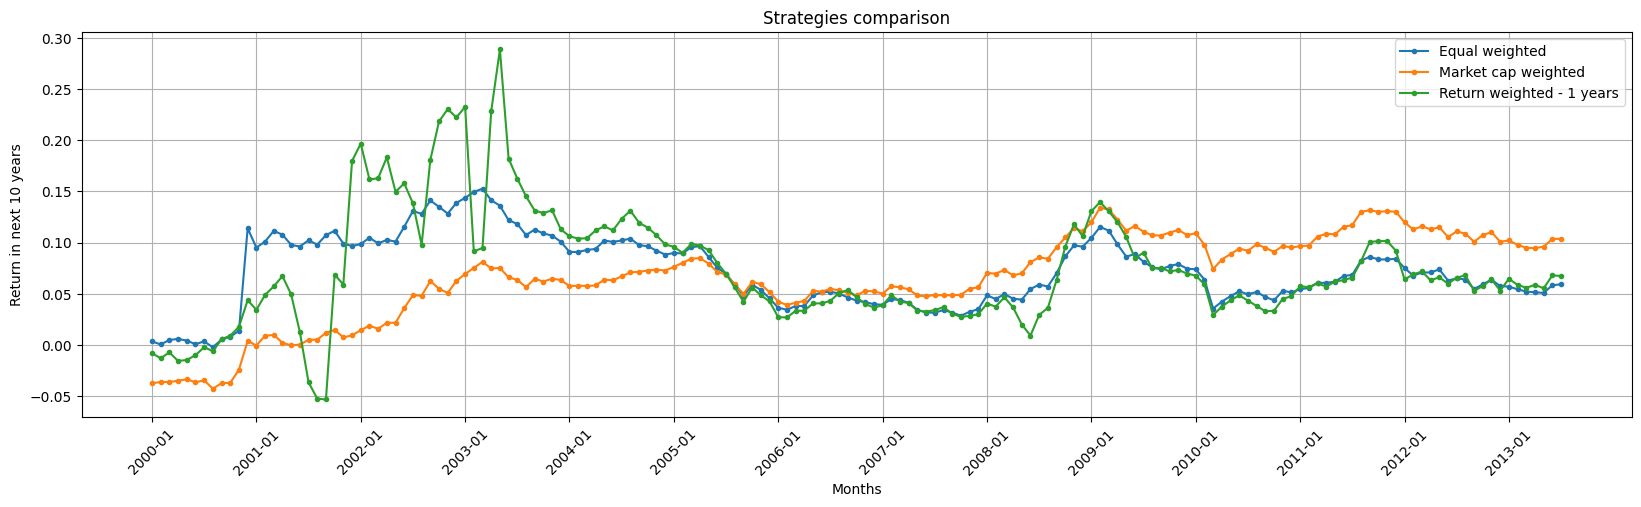

In [193]:
plt.figure(figsize=(20, 5))

for strategy in strategies:
    plt.plot(results[strategy], label=strategy, marker="o", markersize=3)

dates = data.select(DATE_COLUMN).to_series().to_list()[return_weighted_years*12:-120]
plt.xticks(ticks=range(0, len(dates), 12), labels=dates[::12], rotation=45)

plt.grid()
plt.xlabel("Months")
plt.ylabel(f"Return in next {simulation_years} years")
plt.title("Strategies comparison")
plt.legend()